# Practical Work: Mountain Bike suspension

Tire stiffness:

$$
k_T = \pi p \sqrt{D_W D_T}
$$

With:
* $p$: tire pressure,
* $D_W$: wheel diameter,
* $D_T$: tire diameter,

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.misc import derivative
import pandas as pd
%matplotlib nbagg

In [2]:
p = 2. # Tire pressure in bars
k = 1. # Sprint stiffness
d = 0.1 # Damping
m1 = 40. # Suspended mass
m2 = 2. # Unsuspended mass

In [13]:
class Suspension:
    """
    Mountain Bike Suspension.
    
    Inputs:
    * m: mass
    * k: suspension spring stiffness
    * d: damping
    * ddotxd: drive acceleration [m/s**2]
    """
    def __init__(self, m1 = 2, m2 = 50.,
                 k2 = 50.*9.81/70.e-3, Dw = 26.*0.0254, Dt = 2.*0.0254, p = 2.e5, 
                 d2 = 1., g = 9.81, xd = None,
                 l1 = 26.*0.0254, l2 = 1.,
                 t0 = 0.):
        self.m1 = m1
        self.m2 = m2
        self.k2 = k2
        self.Dw = Dw
        self.Dt = Dt
        self.p  = p
        self.d2 = d2
        self.g  = g
        self.l1 = l1
        self.l2 = l2
        if xd == None:
             def xd(t):
                    return 0*t
        self.xd = xd
        self.solution = pd.DataFrame(columns = ["t", "x1", "x2", "dotx1", "dotx2"],
                                     data = [[t0, l1, l2, 0., 0.]])
    
    def k1(self):
        """
        Tire stiffness
        """
        return np.pi * self.p * np.sqrt(self.Dw * self.Dt)
    
    def F01(self, X, t):
        """
        """
        k1 = self.k1()
        l1 = self.l1
        xd = self.xd(t)
        x1, x2, dotx1, dotx2 = X
        dx1 = x1-xd-l1
        F01 = -k1*dx1
        return F01
    
    def F12(self, X, t):
        k2 = self.k2
        d2 = self.d2
        l2 = self.l2
        xd = self.xd(t)
        dotxd = derivative(self.xd, t)
        x1, x2, dotx1, dotx2 = X
        dx2 = x2-x1-l2
        dotdx2 = dotx2 - dotx1
        
        F12 = -k2*dx2 - d2*dotdx2 
        return F12
        
        
    def derivative(self, X, t):
        """
        ODE
        """
        g  = self.g
        m1, m2 = self.m1, self.m2
        x1, x2, dotx1, dotx2 = X
        F01 = self.F01(X, t)
        F12 = self.F12(X, t)
        ddotx1 = (F01 - F12) / m1 - g 
        ddotx2 = F12 / m2 - g
        return np.array([dotx1, dotx2, ddotx1, ddotx2])
    
    def solve(self, nt = 100, dt = 1.e-2):
        """
        Solves the equation
        """
        X0 = self.solution.iloc[-1][["x1", "x2", "dotx1", "dotx2"]].values
        t0 = self.solution.t.values[-1]
        t  =  np.arange(nt+1) * dt + t0
        sol = odeint(self.derivative, X0, t)
        new_data = pd.DataFrame(columns = ["t", "x1", "x2", "dotx1", "dotx2"],
            data = np.array([t, sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3]]).T)
        self.solution = pd.concat([self.solution, new_data], 
                                  ignore_index = True)
        

In [36]:
class Bump:
    """
    A class creating a bump on the track
    """
    def __init__(self, V = 1., S = 1., o = 1., h = 1.):
        self.V = V
        self.S = S
        self.lf = lf
        self.lu = lu
        self.lt = lt
        self.ld = ld
        
    def xd(self, t):
        V = self.V
        S = self.S
        lf = self.lf
        lu = self.lu
        lt = self.lt
        ld = self.ld
        xd =  ((t > V*lf)      & (t <= V*(lf+lu)))    * S * (V*t-lf)
        xd += ((t > V*(lf+lu)) & (t <= V*(lf+lu+lt))) * S * (lf-lu)
        


def xd(t):
    f = 1.
    return .2* np.sin(2. * np.pi *f * t)
s = Suspension(d2 = 100., xd = xd)
s.k1()
s.solve(nt = 1000, dt = 1.e-2)
s.solution.head()

,t,x1,x2,dotx1,dotx2
0,0.00,0.660400,1.000000,0.000000,0.000000
1,0.00,0.660400,1.000000,0.000000,0.000000
2,0.01,0.609700,1.003550,-2.694646,0.684666
3,0.02,0.652237,1.014324,6.872084,1.510616
4,0.03,0.668475,1.033636,-2.917380,2.311883


<IPython.core.display.Javascript object>


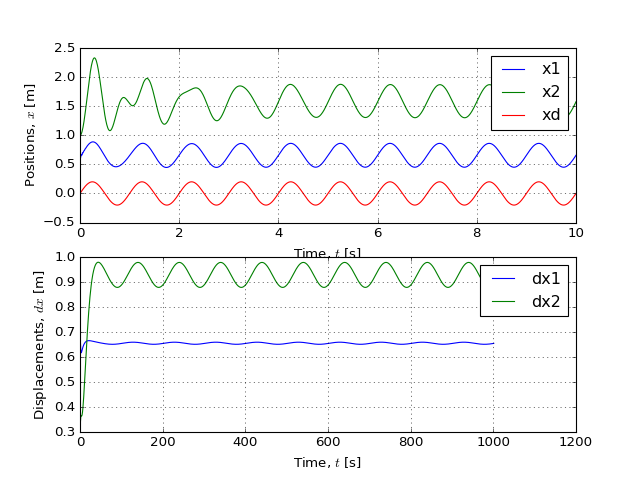

In [35]:
dx1 = d.x1 - s.xd(d.t)
dx2 = d.x2 - d.x1 
d = s.solution
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
plt.plot(d.t, d.x1, label = "x1")
plt.plot(d.t, d.x2, label = "x2")
plt.plot(d.t, s.xd(d.t), label = "xd")
plt.grid()
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Positions, $x$ [m]")
plt.legend()
ax = fig.add_subplot(2,1,2)
plt.plot(dx1 , label = "dx1")
plt.plot(dx2, label = "dx2")
plt.grid()
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Displacements, $dx$ [m]")
plt.legend()

plt.show()

In [6]:
d.xs

<bound method NDFrame.xs of           t        xt        xf     dotxt         dotxf
0    0.0000  0.025400  0.500000  0.000000  0.000000e+00
1    0.0000  0.025400  0.500000  0.000000  0.000000e+00
2    0.0001  0.025400  0.500000 -0.000981 -1.147728e-07
3    0.0002  0.025400  0.500000 -0.001961 -7.873291e-07
4    0.0003  0.025400  0.500000 -0.002940 -2.592359e-06
5    0.0004  0.025399  0.500000 -0.003918 -6.090043e-06
6    0.0005  0.025399  0.500000 -0.004893 -1.184208e-05
7    0.0006  0.025398  0.500000 -0.005866 -2.040971e-05
8    0.0007  0.025398  0.500000 -0.006835 -3.235260e-05
9    0.0008  0.025397  0.500000 -0.007800 -4.822839e-05
10   0.0009  0.025396  0.500000 -0.008760 -6.859245e-05
11   0.0010  0.025395  0.500000 -0.009716 -9.399765e-05
12   0.0011  0.025394  0.500000 -0.010666 -1.249940e-04
13   0.0012  0.025393  0.500000 -0.011610 -1.621277e-04
14   0.0013  0.025392  0.500000 -0.012547 -2.059392e-04
15   0.0014  0.025390  0.500000 -0.013477 -2.569713e-04
16   0.0015  0.02538